In [323]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [324]:
# read daily close price data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
df = pd.read_csv(file_path)
print(df.head())

   PERMNO        date TICKER   BIDLO   ASKHI    PRC      VOL        RET  \
0   11850  1925-12-31    NaN  45.500  46.375  46.00  41400.0          C   
1   11850  1926-01-02    NaN  45.750  46.375  46.00   8400.0   0.000000   
2   11850  1926-01-04    NaN  45.250  46.250  45.50  18700.0  -0.010870   
3   11850  1926-01-05    NaN  45.125  45.625  45.25  17600.0  -0.005495   
4   11850  1926-01-06    NaN  44.875  45.375  45.00   7900.0  -0.005525   

   OPENPRC  
0   45.750  
1   46.375  
2   46.000  
3   45.500  
4   45.125  


In [325]:
# Ensure that the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter the data for a specific date range (example: from 2000-01-01 to 2010-12-31)
start_date = '2015-01-31'
end_train_date = '2018-08-30'
df = df[(df['date'] >= start_date) & (df['date'] <= end_train_date)]

In [326]:
# Keep both the 'date' and 'PRC' columns
df = df[["date", "PRC"]].copy()

# Print the first few rows
print(df.head())

# Display summary statistics
df['PRC'].describe()


            date    PRC
23555 2015-02-02  89.58
23556 2015-02-03  92.25
23557 2015-02-04  91.46
23558 2015-02-05  92.36
23559 2015-02-06  91.50


count    903.000000
mean      82.829003
std        4.708273
min       68.710000
25%       80.160000
50%       82.520000
75%       86.505000
max       95.120000
Name: PRC, dtype: float64

In [327]:
# Ensure the 'date' column is set as the index
df.set_index('date', inplace=True)
# Assign frequency information (daily in this case)
df = df.asfreq('D')  # 'D' stands for daily frequency

In [328]:
# check for missing values
print("Missing values:", df.isnull().sum())

Missing values: PRC    403
dtype: int64


In [329]:
# remove missing values
df = df.dropna()

In [330]:
# Augmented Dickey Fuller (ADF) test to check if the price is stationary

from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df['PRC'])

# Print the result of the ADF test
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used Lag:", adf_result[2])
print("Number of Observations Used:", adf_result[3])
print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")


ADF Statistic: -3.220657765845657
p-value: 0.01881963637693077
Used Lag: 0
Number of Observations Used: 902
Critical Values: {'1%': -3.437620518167552, '5%': -2.8647495822909477, '10%': -2.568478995776815}
Conclusion: The series is stationary


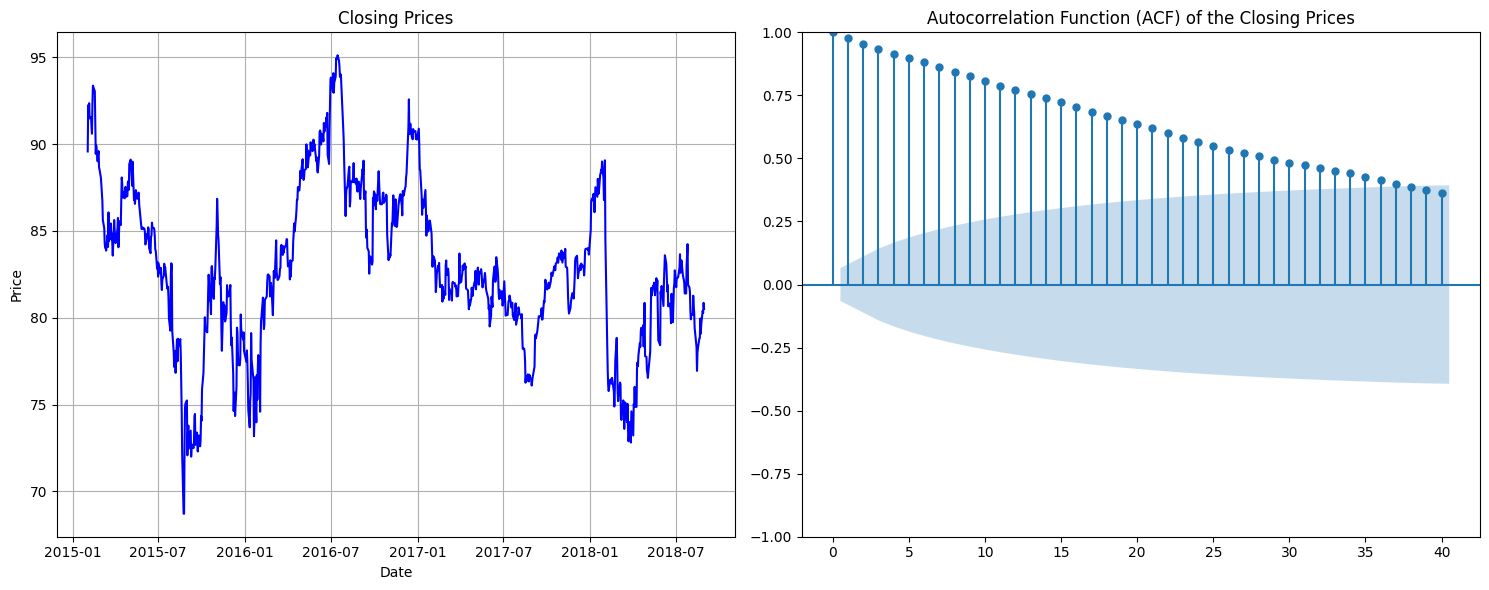

In [331]:
from statsmodels.graphics.tsaplots import plot_acf

# Create a figure with 2 subplots (one for the price and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the closing prices (Price vs Time)
axes[0].plot(df.index, df['PRC'], label="Closing Price", color='blue')
axes[0].set_title("Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price")
axes[0].grid(True)

# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(df['PRC'], lags=40, ax=axes[1])  # lags=40 shows the ACF for up to 40 lags
axes[1].set_title('Autocorrelation Function (ACF) of the Closing Prices')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


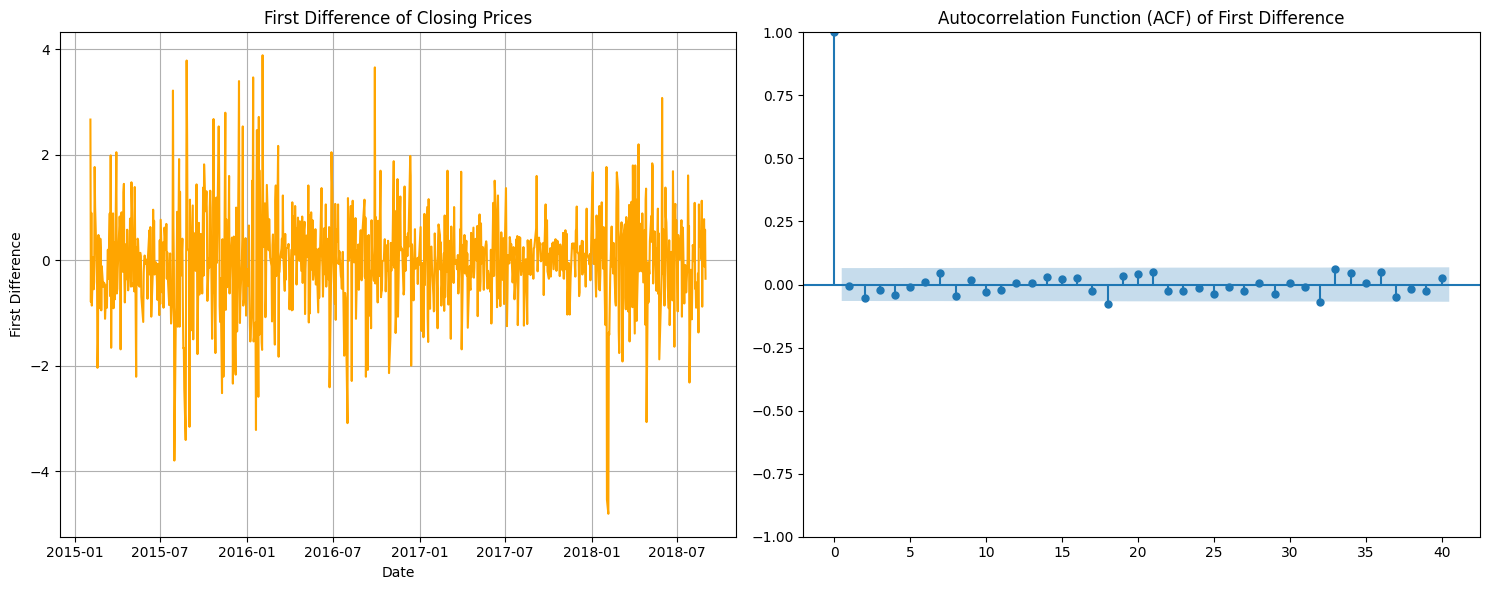

In [332]:
# Calculate the first difference of the closing prices
df['first_difference'] = df['PRC'].diff()

# Create a figure with 2 subplots (one for the first difference and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first difference (First Difference vs Time)
axes[0].plot(df.index, df['first_difference'], label="First Difference", color='orange')
axes[0].set_title("First Difference of Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("First Difference")
axes[0].grid(True)

# Plot the ACF for the first difference (on the second subplot)
plot_acf(df['first_difference'].dropna(), lags=40, ax=axes[1])  # dropna() to avoid NaN values
axes[1].set_title('Autocorrelation Function (ACF) of First Difference')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

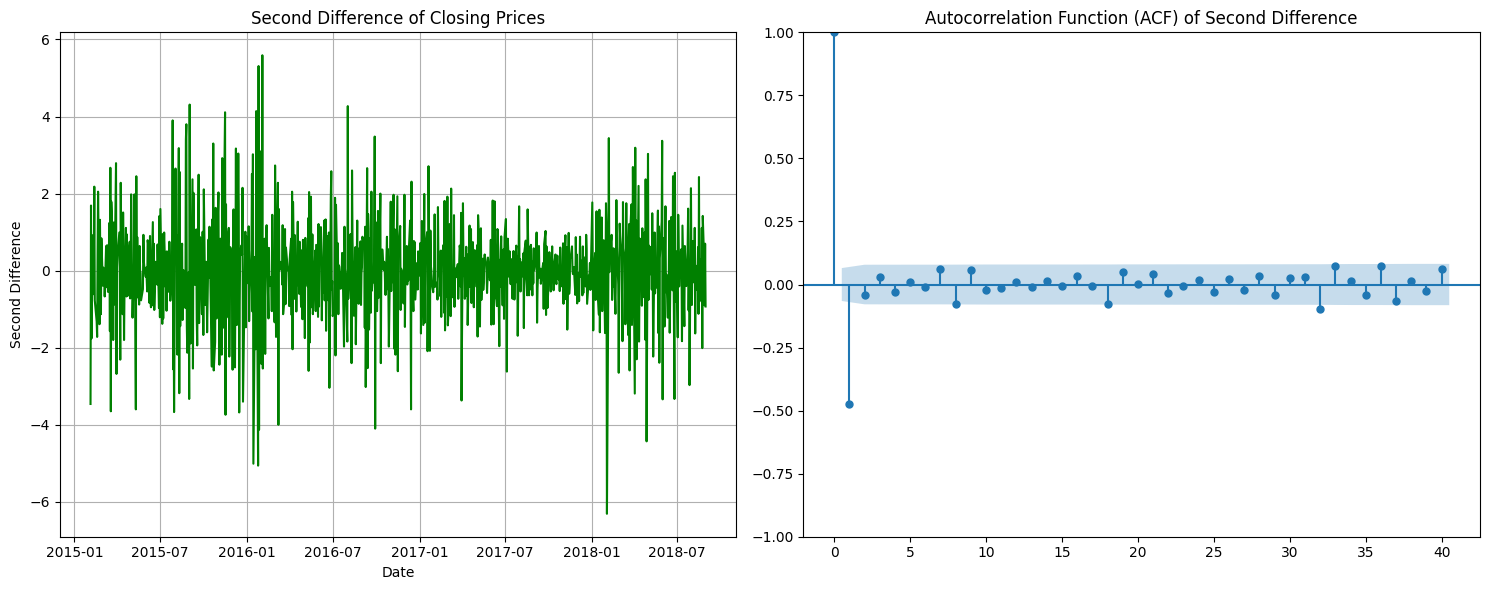

In [333]:
# Calculate the second difference (difference of the first differences)
df['second_difference'] = df['first_difference'].diff()

# Create a figure with 2 subplots (one for the second difference and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the second difference (Second Difference vs Time)
axes[0].plot(df.index, df['second_difference'], label="Second Difference", color='green')
axes[0].set_title("Second Difference of Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Second Difference")
axes[0].grid(True)

# Plot the ACF for the second difference (on the second subplot)
plot_acf(df['second_difference'].dropna(), lags=40, ax=axes[1])  # dropna() to avoid NaN values
axes[1].set_title('Autocorrelation Function (ACF) of Second Difference')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [334]:
from pmdarima.arima.utils import ndiffs

# Remove missing values (NaN) from the 'PRC' column
cleaned_prc = df['PRC'].dropna()

# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(cleaned_prc)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")


Optimal number of differences (d): 1


<Figure size 1000x600 with 0 Axes>

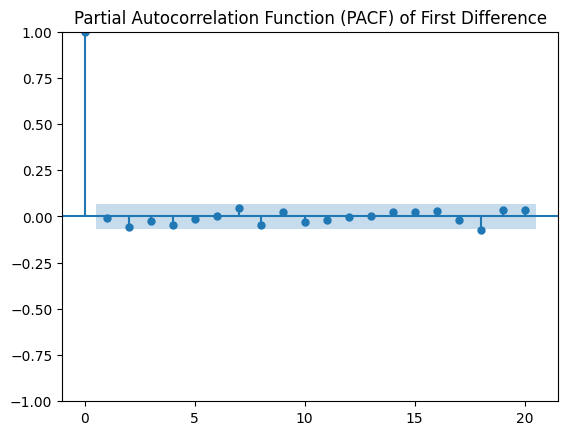

In [335]:
# p is the order of the autoregressive term

from statsmodels.graphics.tsaplots import plot_pacf

# Plot the PACF for the first difference
plt.figure(figsize=(10, 6))
plot_pacf(df['first_difference'].dropna(), lags=20)  # dropna() to avoid NaN values
plt.title('Partial Autocorrelation Function (PACF) of First Difference')
plt.show()


In [336]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (AR(2), I(1), MA(2)) based on the PACF
model = ARIMA(df['PRC'], order=(2, 1, 1))  # AR(2), I(1), MA(2)
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    PRC   No. Observations:                  903
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1239.474
Date:                Thu, 21 Nov 2024   AIC                           2486.947
Time:                        13:09:35   BIC                           2506.166
Sample:                             0   HQIC                          2494.288
                                - 903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5887      0.279      2.113      0.035       0.043       1.135
ar.L2         -0.0518      0.028     -1.836      0.066      -0.107       0.003
ma.L1         -0.5984      0.277     -2.158      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


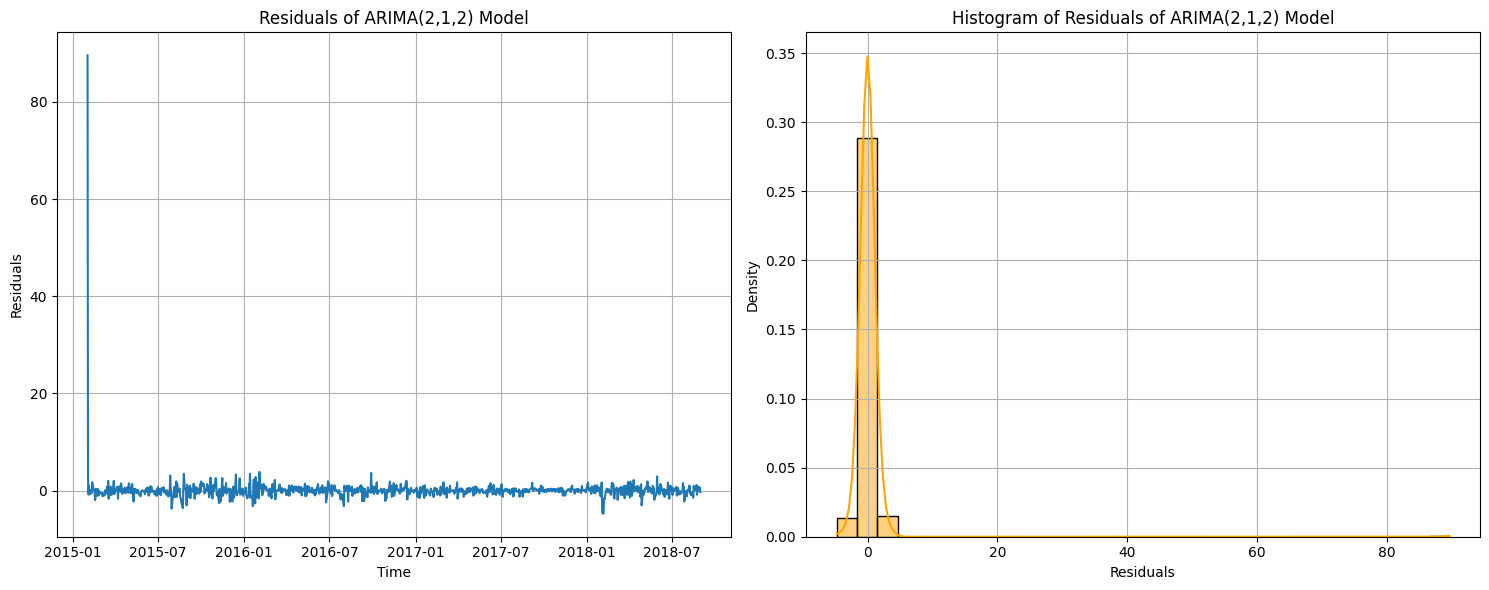

In [337]:
# Get the residuals (difference between observed and fitted values)
residuals = model_fit.resid

# Create a figure with 2 subplots (one for residuals and one for histogram)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the residuals
axes[0].plot(residuals)
axes[0].set_title('Residuals of ARIMA(2,1,2) Model')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Plot the histogram of residuals
sns.histplot(residuals, kde=True, bins=30, color='orange', stat='density', ax=axes[1])  # KDE = Kernel Density Estimation
axes[1].set_title('Histogram of Residuals of ARIMA(2,1,2) Model')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

In [338]:
# Get the fitted values (predicted prices)
fitted_values = model_fit.fittedvalues

# Define the range of dates for the zoomed-in plot
start_date = df.index[3500]  # Adjust this index to the start of your desired section
end_date = df.index[3600]   # Adjust this index to the end of your desired section

# Create a figure with 2 subplots (zoomed-out and zoomed-in)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the zoomed-out actual vs fitted prices (full range)
axes[0].plot(df.index, df['PRC'], label='Actual Prices', color='blue')
axes[0].plot(df.index, fitted_values, label='Fitted Prices', color='orange', linestyle='--')
axes[0].set_title('Actual vs Fitted Prices (Zoomed Out)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Plot the zoomed-in actual vs fitted prices (subset of data)
axes[1].plot(df.loc[start_date:end_date].index, df.loc[start_date:end_date, 'PRC'], label='Actual Prices', color='blue')
axes[1].plot(df.loc[start_date:end_date].index, fitted_values.loc[start_date:end_date], label='Fitted Prices', color='orange', linestyle='--')
axes[1].set_title('Actual vs Fitted Prices (Zoomed In)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


IndexError: index 3500 is out of bounds for axis 0 with size 903

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


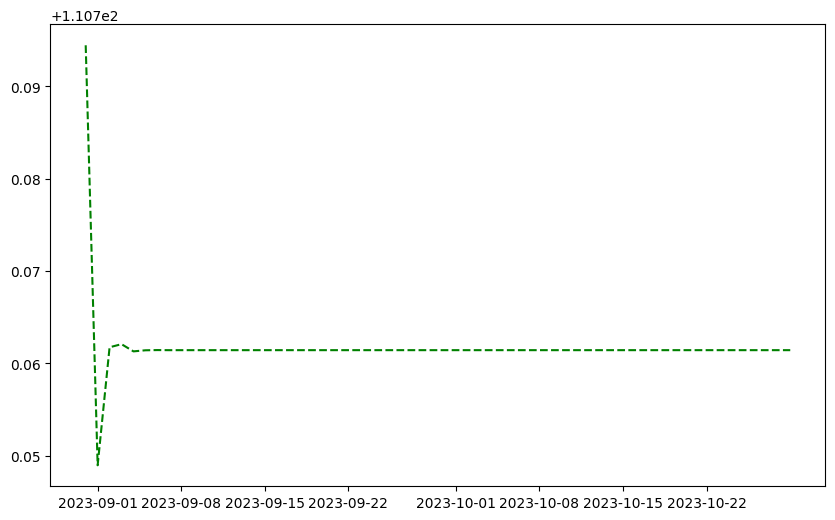

In [ ]:
# Forecast the next 60 steps beyond the training data (e.g., 60 future periods)
forecast_steps = 60
forecast_results = model_fit.get_forecast(steps=forecast_steps)
# Forecasted values
forecast_values = forecast_results.predicted_mean

plt.figure(figsize=(10, 6))

# Plot the forecasted values (future predictions beyond the training period)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:]  # Generate future dates
plt.plot(forecast_index, forecast_values, label='Forecasted Prices', color='green', linestyle='--')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


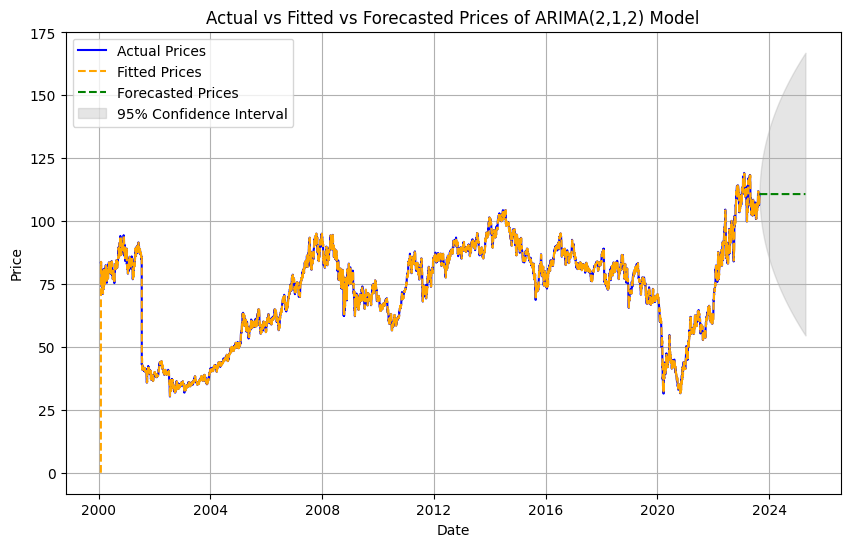

In [ ]:
# Forecast the next 60 steps beyond the training data (e.g., 60 future periods)
forecast_steps = 600
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Standard error of the forecast
stderr = forecast_results.se_mean

# Confidence intervals for the forecast
conf_int = forecast_results.conf_int(alpha=0.05)

# Plot actual vs fitted vs forecasted prices
plt.figure(figsize=(10, 6))

# Plot the actual values (training data)
plt.plot(df.index, df['PRC'], label='Actual Prices', color='blue')

# Plot the fitted values (model predictions for the training period)
plt.plot(df.index, fitted_values, label='Fitted Prices', color='orange', linestyle='--')

# Plot the forecasted values (future predictions beyond the training period)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:]  # Generate future dates
plt.plot(forecast_index, forecast_values, label='Forecasted Prices', color='green', linestyle='--')

# Add confidence intervals for the forecast
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')

# Customize the plot
plt.title('Actual vs Fitted vs Forecasted Prices of ARIMA(2,1,2) Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarnin

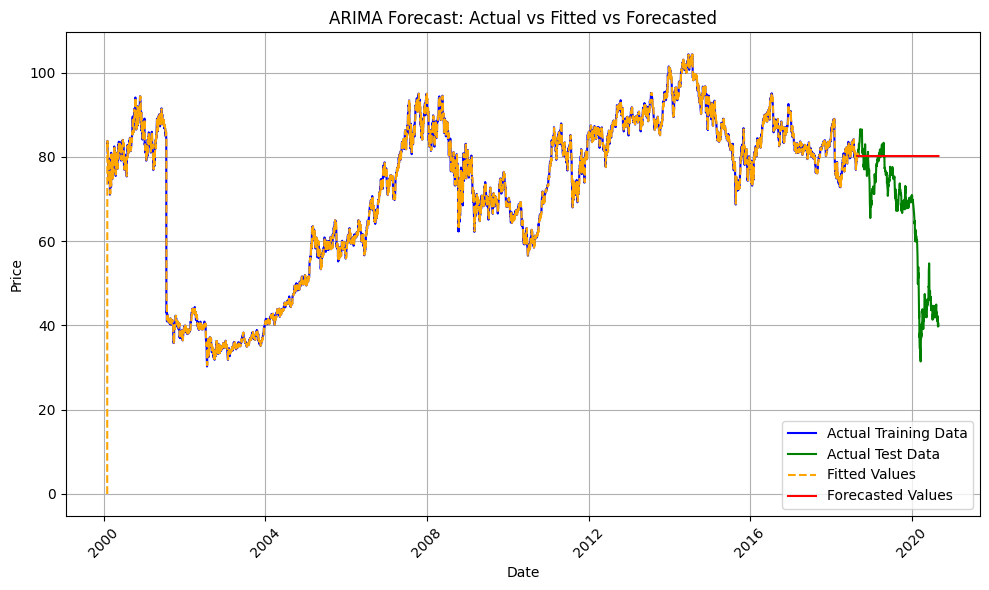

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Define the specific date ranges for the train, validation, and test sets
train_val_start_date = '2000-01-31'
test_start_date = '2018-08-31'
test_end_date = '2020-08-31'

# Split the data into training and testing sets based on the specific dates
train_data = df['PRC'][:test_start_date]  # Training data from the start up to the test start date
test_data = df['PRC'][test_start_date:test_end_date]  # Testing data between test start and end dates

# Fit the ARIMA model (AR(2), I(1), MA(1)) on the training data only
model = ARIMA(train_data, order=(2, 1, 1))  # AR(2), I(1), MA(2)
model_fit = model.fit()

# Forecast the next 'len(test_data)' values (out-of-sample prediction)
forecast_values = model_fit.forecast(steps=len(test_data))

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Plot the actual training data
plt.plot(train_data.index, train_data, label='Actual Training Data', color='blue')

# Plot the actual test data
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')

# Plot the fitted values (predictions on training data)
fitted_values = model_fit.fittedvalues
plt.plot(train_data.index, fitted_values, label='Fitted Values', color='orange', linestyle='--')

# Plot the forecasted values
forecast_index = test_data.index  # The forecasted values will use the test data's index
plt.plot(forecast_index, forecast_values, label='Forecasted Values', color='red', linestyle='-')

# Add titles and labels
plt.title('ARIMA Forecast: Actual vs Fitted vs Forecasted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
